# Отбор признаков 

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

При таком разнообразии способов, позволяющих сгенерировать новые
признаки, у вас, возможно, возникнет искушение увеличить размерность 
данных, превысив количество исходных признаков. Однако добавление 
новых признаков делает модели более сложными и поэтому увеличивает 
вероятность переобучения. Добавляя новые признаки или работая с
высокоразмерными наборами данных, неплохо бы уменьшить количество 
признаков и оставить только наиболее полезные из них.
Это позволит получить более простые модели с лучшей обобщающей способностью. 

**Однако как узнать, насколько полезен каждый признак?** 

Существуют три основные стратегии: **одномерные статистики** (univariate statistics), **отбор
на основе модели** (model-based selection) и **итеративный отбор** (iterative
selection).
*Все эти методы относятся методам машинного обучения с учителем, то есть для подгонки 
модели им требуется зависимая переменная. Это означает, что нам нужно 
разбить данные на обучающий и тестовый наборы и осуществить отбор 
признаков лишь на обучающей выборке*.


### Одномерные статистики

С помощью одномерных статистик мы определяем наличие 
статистически значимой взаимосвязи между каждым признаком и
зависимой переменной. Затем отбираем признаки, сильнее всего 
связанные с зависимой переменной (имеющие уровень значимости, не 
превышающий заданного порогового значения). В случае классификации
эта процедура известна как **дисперсионный анализ (ANOVA)**. Ключевым 
свойством этих тестов является то, что они являются одномерными, то 
есть они рассматривают каждую характеристику по отдельности. 
Следовательно признак будет исключен, если он становится
информативным лишь в сочетании с другим признаком. Как правило, 
одномерные тесты очень быстро вычисляются и не требуют построения 
модели. С другой стороны, они являются полностью независимыми от 
модели, которой вы, возможно, захотите применить после отбора
признаков.

Чтобы осуществить одномерный отбор признаков в scikit-learn, вам 
нужно выбрать тест, обычно либо **f_classif** (по умолчанию) для 
классификации или **f_regression** для регрессии, а также метод 
исключения признаков, основанный на *р-значениях*, вычисленных в ходе
теста. Все методы исключения параметров используют пороговое 
значение, чтобы исключить все признаки со слишком высоким *р-значением* (высокое p-значение указывает на то, что признак вряд ли 
связан с зависимой переменной). Методы отличаются способами
вычисления этого порогового значения, самым простым из которых 
являются **SelectKB**, выбирающий фиксированное число k признаков, и 
**SelectPercentile**, выбирающий фиксированный процент признаков.

In [2]:
from sklearn.feature_selection import SelectPercentile, f_classif

In [3]:
cancer = load_breast_cancer()

# задаем определенное стартовое значение для воспроизводимости результата
rng = np.random.RandomState(42)

# добавляем к данным шумовые признаки
noise = rng.normal(size=(len(cancer.data), 50))

# первые 30 признаков являются исходными, остальные 50 являются шумовыми
X_w_noise = np.hstack([cancer.data, noise])
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)

# используем f_classif (по умолчанию)
# и SelectPercentile, чтобы выбрать 50% признаков
select = SelectPercentile(score_func=f_classif, percentile=50)
select.fit(X_train, y_train)

# преобразовываем обучающий набор
X_train_selected = select.transform(X_train)
 
print("форма массива X_train: {}".format(X_train.shape))
print("форма массива X_train_selected: {}".format(X_train_selected.shape))

форма массива X_train: (284, 80)
форма массива X_train_selected: (284, 40)


[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


Text(0.5, 0, 'Индекс примера')

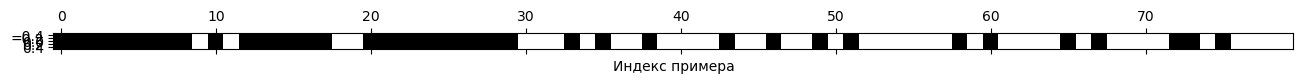

In [4]:
mask = select.get_support()
print(mask)
# визуализируем булевы значения: черный – True, белый – False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Индекс примера")

Благодаря визуализации видно, что большинство отобранных 
признаков являются исходными характеристиками, а большинство 
шумовых признаков были удалены. Тем не менее восстановление 
исходных признаков далеко от идеала.

In [5]:
from sklearn.linear_model import LogisticRegression

# преобразовываем тестовые данные
X_test_selected = select.transform(X_test)
lr = LogisticRegression(max_iter=1000);
lr.fit(X_train, y_train)
print("Правильность со всеми признаками: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Правильность только с отобранными признаками: {:.3f}".format(
lr.score(X_test_selected, y_test)))

C:\Users\dermi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Правильность со всеми признаками: 0.930
Правильность только с отобранными признаками: 0.937


C:\Users\dermi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Это был очень простой синтетический пример, результаты, 
получающиеся на реальных данных, как правило, получаются 
смешанными. Однако одномерный отбор признаков может быть очень 
полезен, если их количество является настолько большим, что 
невозможно построить модель, используя все эти характеристики, или 
же вы подозреваете, что многие характеристики совершенно 
неинформативны.

### Отбор признаков на основе модели

Отбор признаков на основе модели использует модель машинного 
обучения с учителем, чтобы вычислить важность каждого признака, и 
оставляет только самые важные из них. **Модель машинного обучения с 
учителем, которая используется для отбора признаков, не должна
использоваться для построения итоговой модели.**

------------
Модель, применяющаяся для отбора признаков, требует вычисления 
определенного показателя важности для всех признаков, с тем чтобы
характеристики можно было ранжировать по этой метрике. В деревьях
решений и моделях на основе дерева решений такой показатель
реализован с помощью атрибута **feature_importances_**, в котором 
записывается важность каждого признака. У линейных моделей есть
коэффициенты, абсолютные значения которых также можно
использовать для оценки важности признаков. 

Как мы знаем, **линейные модели с L1 регуляризацией** позволяют вычислить разреженные 
решения, которые используют лишь небольшое подмножество 
признаков. Поэтому процедуру L1 регуляризации можно рассматривать 
как один из способов отбора признаков, выполняемый самой моделью.
Кроме того, эту процедуру можно использовать в качестве инструмента 
предварительной обработки, позволяющего отобрать признаки для 
другой модели. 

----------------
*В отличие от одномерного отбора отбор на основе модели 
рассматривает все признаки сразу и поэтому может обнаружить
взаимодействия (если модель способна выявить их).*

Чтобы применить отбор на основе модели, мы должны воспользоваться модификатором **SelectFromModel**

In [6]:
from sklearn.feature_selection import SelectFromModel

In [7]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
select = SelectFromModel(random_forest, threshold='median')

Класс SelectFromModel отбирает все признаки, у которых показатель 
важности (заданный моделью машинного обучения с учителем) 
превышает установленное пороговое значение. Чтобы вычислить
результат, сопоставимый с тем, который мы получили при
однофакторном отборе признаков, мы использовали в качестве 
порогового значения медиану, поэтому будет отобрана половина 
признаков.

In [ ]:
select.fit(X_train, y_train) # обучение

X_train_selected = select.transform(X_train) # отбор 

print("форма обуч набора X: {}".format(X_train.shape))
print("форма обуч набора X c l1: {}".format(X_train_selected.shape))

In [ ]:
mask = select.get_support()
# визуализируем булевы значения -- черный – True, белый – False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Индекс примера")

In [ ]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_selected, y_train).score(X_test_l1, y_test)
print("Правильность на тестовом наборе: {:.3f}".format(score))

*Использовав более оптимальный отбор признаков, мы смогли 
немного улучшить прогноз*

### Итеративный отбор признаков

В одномерном отборе признаков мы не использовали модель, а в отборе 
признаков на основе модели мы построили одну модель, чтобы выбрать
характеристики. В итеративном отборе признаков строится 
последовательность моделей с различным количеством признаков. 
Существует два основных метода.

- Первый метод начинается шага, когда 
в модель включена лишь одна константа (входных признаков нет) и
затем добавляет признак за признаком до тех пор, пока не будет 
достигнут критерий остановки. 


- Второй метод начинается с шага, когда 
все признаки включены в модель, и затем начинает удалять признак за 
признаком, пока не будет достигнут критерий остановки. 

*Поскольку строится последовательность модели, эти методы с вычислительной 
точки зрения являются гораздо более затратными в отличие от ранее 
обсуждавшихся методов*. 

Одним из таких методов является **метод 
рекурсивного исключения признаков**(recursive feature elimination, **RFE**), 
который начинается с включения всех признаков, строит модель и 
исключает наименее важный признак с точки зрения модели. Затем 
строится новая модель с использованием всех признаков, кроме 
исключенного, и так далее, пока не останется лишь заранее определенное 
количество признаков. Чтобы все получилось, модели, используемой для 
отбора признаков, необходима определенная метрика, измеряющая
важность признаков, как было в случае с модельным отбором.

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
select = RFE(random_forest, n_features_to_select=40)

select.fit(X_train, y_train)

# визуализируем отобранные признаки:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Индекс примера")

*Отбор признаков стал лучше по сравнению с одномерным отбором и 
отбором на основе модели, однако одного признака по-прежнему не 
хватает. Кроме того, выполнение этого программного кода занимает 
значительно больше времени в отличие от модельного отбора, поскольку 
модель случайного леса обучается 40 раз, по одной итерации для каждого 
отбрасываемого признака.*

In [ ]:
X_train_rfe= select.transform(X_train)
X_test_rfe= select.transform(X_test)
score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Правильность на тестовом наборе: {:.3f}".format(score))

## Вместо вывода

Если у вас нет уверенности в том, какие признаки использовать в 
качестве входных данных для вашего алгоритма машинного обучения, 
автоматический отбор признаков может быть весьма полезен. Кроме того, 
он отлично подходит для уменьшения количества необходимых 
признаков, например, чтобы увеличить скорость вычисления прогнозов 
или получить более интерпретируемые модели. В большинстве реальных 
примеров применение отбора признаков вряд ли обеспечит большой 
прирост производительности. Тем не менее, он по-прежнему является 
ценным инструментом в арсенале специалиста по анализу данных.
